# Practical Part of Assignment 1 - IFT6135-H19

**Team member**: 
- Qiang Ye (20139927)
- Ying Xiao (20111402)
- Boumaza Amel (20126028)
- Yunhe Li (20137167)

## Support for Computation on Google Colab

In [2]:
from os.path import exists
from google.colab import drive
import os
drive.mount('/content/dirve/', force_remount = True)

Mounted at /content/dirve/


In [0]:
# check if we are in the right working directory
# change to your own directory

os.chdir("dirve/My Drive/Colab Notebooks/IFT6135/hw1/")
#!ls -al

## Problem 2 - CNN on MNIST dataset

We use `Pytorch` to implement a CNN network.

**Code Link**:  https://github.com/qqiang00/IFT6135/blob/master/hw1/prob2_hw1_final.ipynb


### 1. Preparation

#### 1). Import Torch, GPU

In [14]:
from utils import debug, print_progress
import torch, torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import pickle
import gzip
import copy
import sys
import PIL
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.optim import lr_scheduler

# use GPU as priority if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    use_cuda = True
else:
    device = torch.device('cpu')
    use_cuda = False
    
torch.set_default_tensor_type(torch.FloatTensor)
print(device)

DEBUG = True

cuda


### 2. Build a CNN

To describe a CNN architecture, we use the following notations:

- Conv(n_input_channels, n_output_channels, **kernel_size = 3, stride_size = 1, padding_size = 0**), square kernels, for a convolutional operation.
- MaxPool: for a default max pooling and subsampling operation using kernel_size = 2, stride = 2, square kernels.
- Linear(n_input, n_output): for a Linear operation.
- ReLU: for a ReLU activation operation.
- BatchNorm: a batch normalization operation with number of channels equal to its input layer.
- DropOut: a drop-out operation with probability equals 0.5.

To build a CNN with total number of parameters more or less equal to the number of parameters of the MLP in problem1, we designed a CNN architecture like follows:

ConvNet1: Conv(1, 16) -> ReLU -> Conv(16, 32) -> ReLU -> MaxPool -> Conv(32, 64) -> ReLU -> Conv(64, 128) -> ReLU -> MaxPool -> Conv(128, 128, 3, 3, 1) -> ReLU -> Conv(128, 128, 3, 3, 1) -> ReLU -> Conv(128, 128, 3, 3, 0) -> ReLU -> MaxPool() -> Linear(128, 64) -> ReLU -> Linear(64, 10)

In this architecture, only `kernel_size = 3` is used for a convolutional operation, and for most of the convolutional operation, we use `stride = 1, padding = 0`. Concerning of fitting the requirement of the  number of total parameters, we added two convolutional layers with a `padding =1`, to maintain the size of the feature map while increase the number of parameters. Finally, total number of parameters of this CNN is **550058**, which is very close to the total number (**535818**) of parameters of the MLP with hidden dims (512, 256). 

To be fair, we didn't import BatchNorm and DropOut operation in this architeture.


In [0]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.name = type(self).__name__

    def net_name(self):
        return self.name
    
    def count_parameters(self):
        """count number of parameters of current model
        """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class ConvNet(MyModule):
    """CNN with best result"""
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 0),      # 26
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, 0),     # 24
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),             # 12
            nn.Conv2d(32, 64, 3, 1, 0),     # 10
            #nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 1, 0),    # 8
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),             # 4
            nn.Conv2d(128, 128, 3, 1, 1),   # 4
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),   # 4
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 0),   # 2 
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)              # 1
        )
        
        #self.fc_drop = nn.Dropout(p = 0.5)
        self.relu = nn.ReLU() 
        self.fc1 = nn.Linear(128, 64)              
        self.fc2 = nn.Linear(64, 10)               
        # total parameters: 548810
        
    def forward(self, x):                             # 1    28   28
        x = self.conv(x)                              # 128    1    1 
        x = x.view(x.size(0), -1)                     # batch, 128
        # x = self.fc_drop(x)
        x = self.relu(self.fc1(x))                    # batch, 64
        x = self.fc2(x)                               # batch, 10
        return x    

### 3. Train the Model and Plot Learning Curve

#### 1). Build `train_model` method

In [0]:
def train_model(model, 
                learning_rate,
                train_dataset,
                valid_dataset,
                auto_save_path,
                best_model_path,
                scheduler = None, 
                max_epochs = 20, 
                early_stopping = False, 
                epoch_patience = 5,
                auto_load_best_after_train = True,
                auto_save_interval = 1,
                batch_size = 256,
                show_live_progress = False,
                trainer = "Ying"
                ):
    """train a model
    Params
        model: to be trained, nn.Module
        train_valid_set: merge of training and validating set
        n_valid_sample: number of validating samples
        scheduler: learning rate scheduler
        auto_save_path: path where latest model will be auto saved
        best_model_path: path where best model will be saved
        max_epochs: max epochs, int
        early_stopping: decide if training will stop earlier according to 
            accuracy on validating dataset, Bool
        epoch_patience: if accuracy on validate set decreases, we don't stop
            at the epoch, we need to go extra epoch_patience number of epoch
            to confirm this decreasing trends, int
        auto_load_best_after_train: whether we load our best model paramters
            after the training process is complete, Bool
        auto_save_interval: the interval we auto save the parameters of the 
            model, int
        batch_size: batch_size, int      
    Returns
        # model: trained, nn.Module
        losses: losses during training and validating, 
            dict {"train", [double], 'val': [double]}
        accuracies: accuracies during training and validating, 
            dict {"train", [double], 'val': [double]}
        cache: a cache dict {'best_model_wts':best_model_wts,
                             'best_acc_val':best_acc_val,
                             'optimizer':optimizer,
                             'model':model
                            }
    """
    
    model.to(device)
    dataset_sizes = {
        'train': len(train_dataset),
        'val': len(valid_dataset)
    }
    dataloaders = {
        'train':torch.utils.data.DataLoader(
            train_dataset,batch_size = batch_size),
        'val':torch.utils.data.DataLoader(
            valid_dataset, batch_size = batch_size)
    }
    print("trainer:{}, model:{}, learning_rate:{}, batch_size:{}".format(
        trainer, model.net_name(), learning_rate, batch_size))
    print("model parameters:{}".format(model.count_parameters()))
    print("training/validation:", len(train_dataset),"/", len(valid_dataset))
    
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr = learning_rate) 
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)

    best_model_wts = copy.deepcopy(model.state_dict())  # for best parameters
    best_acc = {'train':0.0, 'val':0.0}                 # best accuracy
    losses = {'train': [], 'val':[]}
    accuracies = {'train': [], 'val':[]}
    patience_used = 0                                   # patience used
    early_stopped = 0
    debug("'s': auto saved, '*': best accuracy so far.")
    start = time.time()    
    for epoch in range(max_epochs):
        since = time.time()
        # s_before and s_after are for print trainig progress
        s_before = '[Epoch{:>3d}/{} '.format(epoch, max_epochs - 1)
        s_after = ']'
        if show_live_progress:
            print_progress(0, 0, s_before, s_after)
        else:
            print(s_before + s_after, end = "")

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            since_phase = time.time()
            if phase == 'train': # train
                if scheduler is not None:
                    scheduler.step()
                model = model.train()  # Set model to training mode
            else:
                model = model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_size = 0
            if show_live_progress:
                print_progress(0, 0, s_before, s_after)
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                test_start = time.time()
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, dim = 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # accumulate loss and correctly predicted sample number
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.data == labels.data).item()
                running_size += preds.size(0)
                
                if show_live_progress:
                    time_elapsed = time.time() - since_phase
                    print_progress(running_size/dataset_sizes[phase], 
                                   time_elapsed, 
                                   s_before, 
                                   s_after)
                    already_show_estimated_time = True
                test_end = time.time()
                #print(test_end - test_start)
                # end batches loop
                
            # compute average loss and accuracy after a traing or validate phase
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # keep current loss and accuracy data
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            
            time_elapsed = time.time() - since_phase
            s_after += ' {} loss: {:.4f} acc: {:<7.2%} '.format(
                phase, epoch_loss, epoch_acc)
            

            # check current parameters achieved best performance so far
            # if YES, keep a reference to the best parameters.
            if epoch_acc > best_acc[phase]:
                best_acc[phase] = epoch_acc
                if phase == 'val':
                    s_after += " *"
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_used = 0
            else:
                if phase == 'val': # avoid repeating check for both training
                                   # and validating phase
                    patience_used += 1 # 
                    if early_stopping and patience_used >= epoch_patience:
                        # patience is used up
                        early_stopped = epoch - epoch_patience
                        
            if show_live_progress:
                print_progress(running_size/dataset_sizes[phase], 
                               time_elapsed, s_before, s_after)
            else:
                print(' {} loss: {:.4f} acc: {:<7.2%} '.format(
                    phase, epoch_loss, epoch_acc), end = " ")                        
            #end phase loop
    
        time_elapsed = time.time() - since
        if show_live_progress:
            print_progress(1, time_elapsed, s_before, s_after)
        else:
            print(' {:.0f}m{:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60), end = "")
        # display some information
        #if epoch_acc == best_acc['val']:
        #    print("*", end="")
        #else:
        #    print("", end="")
        if early_stopped or epoch == (max_epochs - 1) or \
           (epoch + 1) % auto_save_interval == 0:
            
            model_name = "{}_{}_{}_{}".format(
                trainer, model.net_name(), str(learning_rate), str(batch_size))
            model_path_auto_save = auto_save_path + "_" + model_name + ".model"
            model_path_best = best_model_path + "_" + model_name + ".model"
            
            torch.save(model.state_dict(), model_path_auto_save)
            torch.save(best_model_wts, model_path_best)
            print(" s") # saved
        else:
            print("") # new line

        if early_stopped > 0:
            print("Early stop at epoch: {}".format(early_stopped))
            break
        #end epoch loop 
    
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    for phase in ["train", "val"]:#phases:        
        print('Best val Acc on {}: {:.2%}'.format(phase, best_acc[phase]))
    # load best model weights
    
    if auto_load_best_after_train:
        model.load_state_dict(best_model_wts)
        
    train_info = {
        "best_acc_train": best_acc["train"],
        "best_acc_val": best_acc["val"],
        "time_elapsed": time_elapsed,
        "early_stopped": early_stopped,
        "epoch_passed": epoch + 1,
        "model_name": model_name
    }
    return losses, accuracies, train_info

#### 2). Build  a method for showing learning curve

In [0]:
def learning_curve(losses, accuracies, model_name):
    """plot learning curve
    Params
        losses: a dictionary {"train": [float], "val": [float]}
        accuracies: a dictionary {"train": [float], "val": [float]}
    """
    support = np.arange(len(losses['train']))
    plt.figure(figsize = (14, 6))
    plt.grid(True) # add a grid

    plt.subplot(1,2,1)
    plt.plot(support, losses['train'], 'g-', label = 'train')
    plt.plot(support, losses['val'], 'b-', label = 'val')
    plt.xlabel('epochs')
    plt.ylabel('losses')
    plt.title("Loss curves: {}".format(model_name))
    plt.legend(loc='upper right')
    
    plt.subplot(1,2,2)
    plt.plot(support, accuracies['train'], 'g-', label = 'train' )
    plt.plot(support, accuracies['val'], 'b-', label = 'val')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title("Accuracy curves: {}".format(model_name))
    plt.legend(loc='lower right')
    
    plt.savefig("models/" + model_name + ".png")
    plt.show()

#### 3). Prepare training and validation datasets

In [15]:
def load_data(data_path = "mnist.pkl.gz", dataset_type = "train"):
    """load specified dataset from data_path
    Params
        dataset_type: specify the type of the dataset, str. Example: "train"
        ,"valid", "test"
    Returns
        dataset, tuple (X, y) where shape of X is (sample_size, n_feature), 
        shape of y is (sample_size, )
    """
    with gzip.open(data_path,'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        data_set = u.load()
        # all _data are tuple with 2 elements: X, and y with shape like
        # (50000, 784) and (50000, ) respectively
    dataset_type = dataset_type.upper()
    if dataset_type == "TRAIN":
        return data_set[0]
    elif dataset_type == "VALID":
        return data_set[1]
    else: # test
        return data_set[2]
    

#load datasets(numpy format) from files
train_dataset = load_data(data_path = "mnist.pkl.gz", dataset_type = "train")
valid_dataset = load_data(data_path = "mnist.pkl.gz", dataset_type = "valid")
print(train_dataset[0].shape, train_dataset[1].shape, type(train_dataset[1]))

# convert to torch Tensors with proper shape
train_X = torch.tensor(train_dataset[0].reshape(-1, 1, 28, 28))
train_y = torch.tensor(train_dataset[1])
print(train_X.shape, train_y.shape)
valid_X = torch.tensor(valid_dataset[0].reshape(-1, 1, 28, 28))
valid_y = torch.tensor(valid_dataset[1])
print(valid_X.shape, valid_y.shape)

# generate datasets for torch.utils.data.DataLoader
train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
valid_dataset = torch.utils.data.TensorDataset(valid_X, valid_y)    

(50000, 784) (50000,) <class 'numpy.ndarray'>
torch.Size([50000, 1, 28, 28]) torch.Size([50000])
torch.Size([10000, 1, 28, 28]) torch.Size([10000])


#### 4). Training the model and Plot learning curve

------------------------------
trainer:Qiang, model:ConvNet, learning_rate:0.01, batch_size:32
model parameters:548810
training/validation: 50000 / 10000
's': auto saved, '*': best accuracy so far.
[Epoch  0/9 100.00% 0m25s] train loss: 2.3017 acc: 10.98%   val loss: 2.3017 acc: 10.64%   *
[Epoch  1/9 100.00% 0m24s] train loss: 2.3010 acc: 11.36%   val loss: 2.3016 acc: 10.64%  
[Epoch  2/9 100.00% 0m24s] train loss: 2.3008 acc: 11.36%   val loss: 2.3014 acc: 10.64%  
[Epoch  3/9 100.00% 0m24s] train loss: 2.3004 acc: 11.36%   val loss: 2.3009 acc: 10.64%  
[Epoch  4/9 100.00% 0m24s] train loss: 2.2994 acc: 11.36%   val loss: 2.2989 acc: 10.64%  
[Epoch  5/9 100.00% 0m24s] train loss: 2.2858 acc: 14.69%   val loss: 2.1848 acc: 42.98%   *
[Epoch  6/9 100.00% 0m24s] train loss: 0.5878 acc: 81.76%   val loss: 0.2229 acc: 92.95%   *
[Epoch  7/9 100.00% 0m24s] train loss: 0.1659 acc: 94.86%   val loss: 0.1303 acc: 96.00%   *
[Epoch  8/9 100.00% 0m22s] train loss: 0.1088 acc: 96.62%   val lo

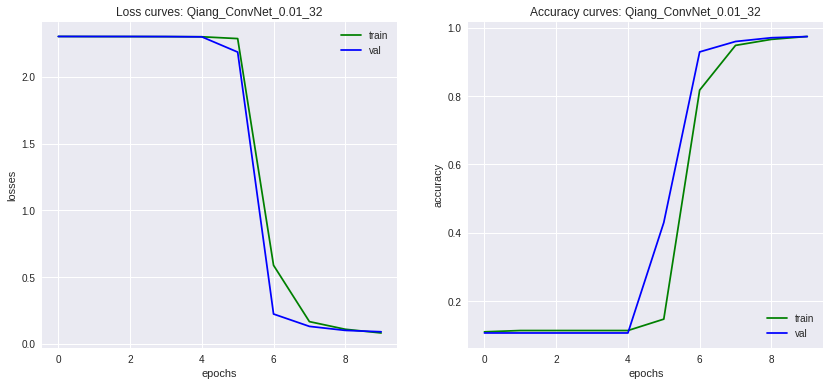

In [16]:
# options for models, learning_rates, and batch_sizes
models = [ConvNet] #[ConvNet1, ConvNet3, ConvNet4] 
learning_rates = [0.01] # [1, 0.1, 0.01, 0.001]
batch_sizes = [32] # [1, 32, 256, 1024]

# if you once interrupted this code cell and want to continue try different
# hyper-parameter settings, you may insert the setting already trained in
# this list.
settings_trained = []
n_models = len(models)
n_lrs =  len(learning_rates)
n_batch_sizes = len(batch_sizes)


# total times of searching is not bigger than number of all possibilities.
n_search = n_lrs * n_batch_sizes
trainer = "Qiang"

for i in range(n_search):
    print("-"* 30)
    model_index, lr_index, batch_size_index = 0, 0, 0
    while True:
        # generate a new hyper-parameter setting
        model_index = np.random.randint(n_models)
        lr_index = np.random.randint(n_lrs)
        batch_size_index = np.random.randint(n_batch_sizes)
        
        setting = (model_index, lr_index, batch_size_index)
        if not setting in settings_trained:
            # setting not trained
            break
    
    model = models[model_index]()
    learning_rate = learning_rates[lr_index]
    batch_size = batch_sizes[batch_size_index]
        
    losses, accuracies, train_info = train_model(
            model = model,
            learning_rate = learning_rate,
            batch_size = batch_size,
            train_dataset = train_dataset,
            valid_dataset = valid_dataset,
            auto_save_path = './models/auto_save',
            best_model_path = './models/best',
            max_epochs = 10, 
            early_stopping = True, 
            epoch_patience = 10,
            auto_load_best_after_train = True, # 
            auto_save_interval = 10,# every 10 epochs, save model parameters
            show_live_progress = True,
            trainer = trainer
        )
    learning_curve(losses, accuracies, train_info["model_name"])
    # add this setting to trained list.
    settings_trained.append(setting)
    # continue new hyper-parameter setting until all combinations are trained.

#### 5). Compare the performance
At the first 6 epochs, training and validation losses almost unchange, while at epoch 6, both decrease steeply with the accuracy on validation dataset arrive at 91.32%. Finally, it achieved 97% validation accuracy at the end of 10th epoch.

With the same hyper-parameters(lr = 0.01, batch_size = 32), same gradient descent trajectory: stochastic gradient descent without momentum, and with almost same total number of trainable parameters, the MLP achieved 97% accuracy on validation dataset at epoch13.

There are some significant differences between MLPs and CNNs. MLP use full connections, doesn't have feature of invariance of transition; whereas a CNN architecture has the invariance of transition, shares weight parameters of kernels, and abstracts features layer by layer. These huge differences make a CNN network usually performs better than a MLP on image recognition tasks, which is supported by our experiment.



**(End of Report of Problem2)**

---
